In [1]:
import pandas as pd
import numpy as np
import torch
import time
import matplotlib.pyplot as plt
import river.metrics as metrics
import river.stream as stream

In [2]:
#!pip install deep-river
#!pip install prettytable
#!pip install tabulate

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from torch import nn, manual_seed
from IPython.display import clear_output
from collections import deque, Counter
from river import metrics, preprocessing, compose, stream
from deep_river import classification

In [4]:
offline_df = pd.read_csv('CICIoMT2024/Train.csv')
offline_df = offline_df.sample(frac=0.01, random_state=42)

In [5]:
online_df = pd.read_csv('CICIoMT2024/Test.csv')
online_df = online_df.sample(frac=0.1, random_state=42)

In [6]:
offline_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71557 entries, 6612853 to 3840050
Data columns (total 46 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Header_Length    71557 non-null  float64
 1   Protocol Type    71557 non-null  float64
 2   Duration         71557 non-null  float64
 3   Rate             71557 non-null  float64
 4   Srate            71557 non-null  float64
 5   Drate            71557 non-null  float64
 6   fin_flag_number  71557 non-null  float64
 7   syn_flag_number  71557 non-null  float64
 8   rst_flag_number  71557 non-null  float64
 9   psh_flag_number  71557 non-null  float64
 10  ack_flag_number  71557 non-null  float64
 11  ece_flag_number  71557 non-null  float64
 12  cwr_flag_number  71557 non-null  float64
 13  ack_count        71557 non-null  float64
 14  syn_count        71557 non-null  float64
 15  fin_count        71557 non-null  float64
 16  rst_count        71557 non-null  float64
 17  HTTP     

In [7]:
online_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 161212 entries, 1088358 to 315349
Data columns (total 46 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Header_Length    161212 non-null  float64
 1   Protocol Type    161212 non-null  float64
 2   Duration         161212 non-null  float64
 3   Rate             161212 non-null  float64
 4   Srate            161212 non-null  float64
 5   Drate            161212 non-null  float64
 6   fin_flag_number  161212 non-null  float64
 7   syn_flag_number  161212 non-null  float64
 8   rst_flag_number  161212 non-null  float64
 9   psh_flag_number  161212 non-null  float64
 10  ack_flag_number  161212 non-null  float64
 11  ece_flag_number  161212 non-null  float64
 12  cwr_flag_number  161212 non-null  float64
 13  ack_count        161212 non-null  float64
 14  syn_count        161212 non-null  float64
 15  fin_count        161212 non-null  float64
 16  rst_count        161212 non-null  flo

In [8]:
# Define the mapping dictionary
label_mapping = {
    'Malformed_Data': 'MQTT',
    'DDoS-ICMP': 'DDoS',
    'DoS-ICMP': 'DoS',
    'DoS-TCP': 'DoS',
    'DDoS-Connect_Flood': 'MQTT',
    'DoS-Connect_Flood': 'MQTT',
    'Benign': 'Benign',
    'DoS-UDP': 'DoS',
    'Ping_Sweep': 'Recon',
    'DDoS-Publish_Flood': 'MQTT',
    'DDoS-SYN': 'DDoS',
    'DDoS-TCP': 'DDoS',
    'DoS-SYN': 'DoS',
    'DDoS-UDP': 'DDoS',
    'Port_Scan': 'Recon',
    'OS_Scan': 'Recon',
    'DoS-Publish_Flood': 'MQTT',
    'VulScan': 'Recon',
    'ARP_Spoofing': 'Spoofing'
}

# Apply the mapping to the 'Label' column
offline_df['Label'] = offline_df['Label'].replace(label_mapping)
online_df['Label'] = online_df['Label'].replace(label_mapping)

In [9]:
print(offline_df['Label'].value_counts())

Label
DDoS        47852
DoS         18067
MQTT         2625
Benign       1914
Recon         934
Spoofing      165
Name: count, dtype: int64


In [10]:
print(online_df['Label'].value_counts())

Label
DDoS        106922
DoS          41459
MQTT          6287
Benign        3789
Recon         2588
Spoofing       167
Name: count, dtype: int64


In [11]:
# Creating a dictionary of Types
attacks = {'DDoS':0,
           'DoS':1,
           'MQTT':2,
           'Benign':3,           
           'Recon':4, 
           'Spoofing':5}

offline_df['Label'] = offline_df['Label'].map(attacks)
online_df['Label'] = online_df['Label'].map(attacks)

# Train Offline Model

In [12]:
X_train = offline_df.drop(columns=['Label'])
y_train = offline_df['Label']
X_train, y_train = shuffle(X_train, y_train, random_state=42)

In [13]:
# Offline training setup
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

offline_model = RandomForestClassifier()
offline_model.fit(X_train, y_train)

RandomForestClassifier()

# Initialize Online Model

In [14]:
# Set random seed for reproducibility
manual_seed(42)

# Split features and labels
X = online_df.drop(columns=['Label'])
y = online_df['Label']
X, y = shuffle(X, y, random_state=42)

In [15]:
# Define RNN for online learning
class MyRNN(nn.Module):
    def __init__(self, n_features):
        super(MyRNN, self).__init__()
        self.rnn = nn.LSTM(input_size=n_features, hidden_size=32, num_layers=1)
        self.fc = nn.Linear(32, 6)
        self.relu = nn.ReLU()  # Activation function
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, X, **kwargs):
        X, _ = self.rnn(X.unsqueeze(0))
        X = self.relu(self.fc(X[:, -1, :]))
        X = self.softmax(X)
        return X

In [16]:
# Initialize the online model pipeline
model_pipeline = preprocessing.StandardScaler() | classification.Classifier(
    module=MyRNN,
    loss_fn='cross_entropy',
    optimizer_fn='adam'
)

In [17]:
# Real-time metrics setup for multi-class evaluation
metrics_dict = {
    'Accuracy': metrics.Accuracy(),    
    'Precision': metrics.MacroPrecision(),  # Macro-average for multi-class
    'Recall': metrics.MacroRecall(),
    'F1-score': metrics.MacroF1()
}

In [18]:
# Lists for tracking metrics over time for visualization
accuracy_values, precision_values, recall_values, f1_values = [], [], [], []

In [19]:
# Buffer for recent prediction accuracy
accuracy_buffer_offline = deque(maxlen=100)
accuracy_buffer_online = deque(maxlen=100)

In [20]:
# Set accuracy threshold for triggering online model updates
accuracy_threshold = 0.99  # Define your acceptable threshold

In [21]:
# Real-time metrics visualization function
def plot_metrics():
    clear_output(wait=True)    
    plt.figure(figsize=(14, 8))    
    plt.plot(accuracy_values, label='Accuracy', color='blue', linestyle='--', alpha=0.7)    
    plt.plot(precision_values, label='Precision', color='green', linestyle='--', alpha=0.7)        
    plt.plot(recall_values, label='Recall', color='orange', linestyle='--', alpha=0.7)        
    plt.plot(f1_values, label='F1-Score', color='red', linestyle='--', alpha=0.7)    
            
    # Set title and labels
    plt.title('Real-Time Metrics for Hybrid Model')
    plt.xlabel('Number of Samples')
    plt.ylabel('Metric Value')
    
    # Add grid and legend
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend(loc='best')
    
    # Show plot   
    plt.show()

In [22]:
# Helper function to update accuracy buffer
def update_accuracy_buffer(buffer, y_true, y_pred):
    buffer.append(int(y_true == y_pred))
    return sum(buffer) / len(buffer)

In [23]:
# Streaming the dataset
dataset = stream.iter_pandas(X, y)
num_samples = 0

In [24]:
# Initialize tracking variables
num_updates = 0
agreement_count = 0
confidence_scores = []
total_time = 0
degradation_instances = 0
hybrid_predictions = []

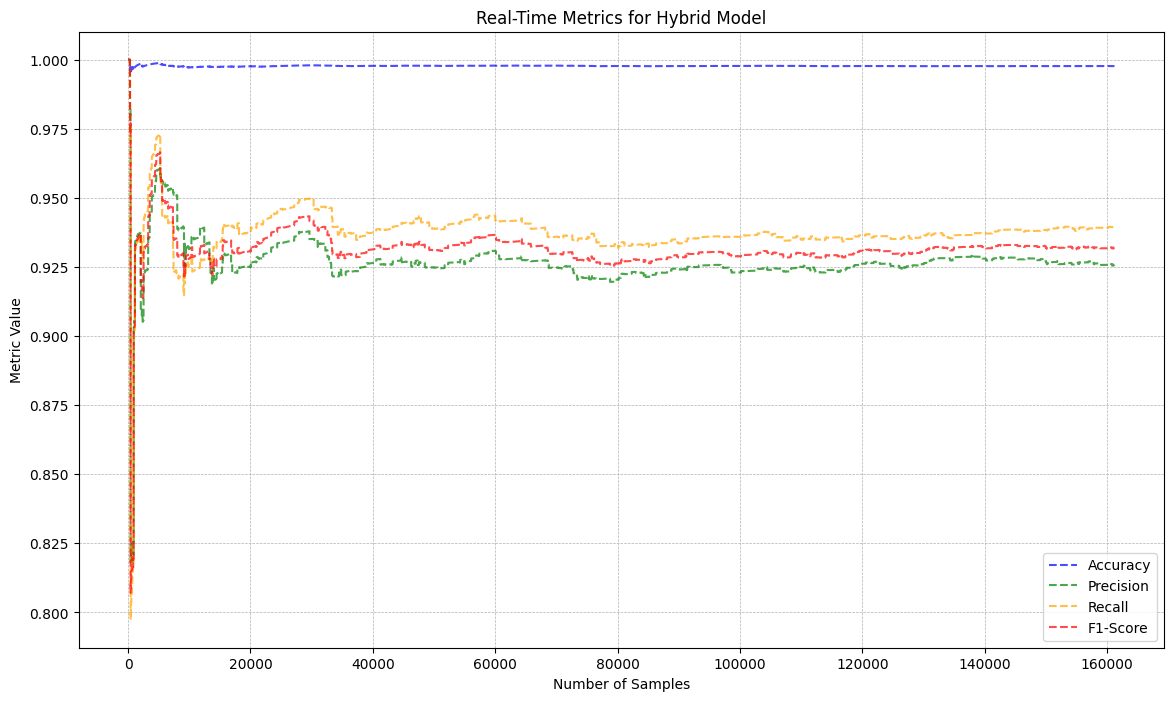

In [25]:
# Main loop for hybrid prediction
for x, y in dataset:
    start_time = time.time()  # Start time for runtime measurement
    
    num_samples += 1
    x_scaled = scaler.transform(pd.DataFrame([x]))  # Scale each streamed instance
    y_pred_offline = offline_model.predict(x_scaled)[0]
    y_pred_online = model_pipeline.predict_one(x)

    # Update accuracy buffers
    offline_accuracy = update_accuracy_buffer(accuracy_buffer_offline, y, y_pred_offline)
    online_accuracy = update_accuracy_buffer(accuracy_buffer_online, y, y_pred_online)

    # Decision logic: Select prediction from model with higher recent accuracy
    y_pred = y_pred_online if online_accuracy >= offline_accuracy else y_pred_offline

    # Check agreement between offline and online models
    if y_pred_offline == y_pred_online:
        agreement_count += 1

    # Append prediction to hybrid_predictions list
    hybrid_predictions.append(y_pred)

     # Calculate confidence score for online prediction, if available
    y_pred_online_prob = model_pipeline.predict_proba_one(x)
    confidence_score = max(y_pred_online_prob.values()) if y_pred_online_prob else None
    if confidence_score is not None:
        confidence_scores.append(confidence_score)

    # Update real-time metrics
    for name, metric in metrics_dict.items():
        metric.update(y, y_pred)
    
    # Append latest metrics for visualization
    accuracy_values.append(metrics_dict['Accuracy'].get())    
    precision_values.append(metrics_dict['Precision'].get())
    recall_values.append(metrics_dict['Recall'].get())
    f1_values.append(metrics_dict['F1-score'].get())
           
    # Online model learning triggered by accuracy threshold
    if online_accuracy < accuracy_threshold:
        model_pipeline.learn_one(x, y)
        num_updates += 1
        degradation_instances += 1
           
    # Plot metrics every 50 samples
    if num_samples % 50 == 0:
        plot_metrics()

    # Runtime calculation
    end_time = time.time()
    total_time += (end_time - start_time)

In [26]:
# Final results after streaming
print("Final Performance Metrics of Hybrid Model:")
for name, metric in metrics_dict.items():
    print(f"{name}: {metric.get():.4f}")

Final Performance Metrics of Hybrid Model:
Accuracy: 0.9977
Precision: 0.9258
Recall: 0.9397
F1-score: 0.9320


In [27]:
# Reverse the dictionary to map index to attack type
index_to_attack = {v: k for k, v in attacks.items()}

# Determine the predicted attack type
predicted_attack_type = index_to_attack.get(y_pred, "Unknown")
online_prediction_type = index_to_attack.get(y_pred_online, "Unknown")

# Generate Hybrid Model Prediction Distribution
hybrid_pred_distribution = Counter(hybrid_predictions)
hybrid_distribution_table = pd.DataFrame([
    {"Attack Type": index_to_attack.get(k, "Unknown"), "Count": v}
    for k, v in hybrid_pred_distribution.items()
])

# Print Results as Table and Case Description
case_description = {
    "Processed Samples": num_samples,
    "Predicted Attack Type": predicted_attack_type,
    "Model Source": "Online" if y_pred == y_pred_online else "Offline",
}

# Display Results
print("Case Description:")
print(pd.DataFrame([case_description]))

print("\nHybrid Model Prediction Distribution:")
print(hybrid_distribution_table)

Case Description:
   Processed Samples Predicted Attack Type Model Source
0             161212                  DDoS       Online

Hybrid Model Prediction Distribution:
  Attack Type   Count
0        DDoS  106923
1         DoS   41452
2      Benign    3955
3        MQTT    6213
4       Recon    2476
5    Spoofing     193


In [28]:
print(f"Average Offline Model Accuracy: {offline_accuracy:.4f}")
print(f"Average Online Model Accuracy: {online_accuracy:.4f}")
print(f"Prediction Agreement Rate: {agreement_count / num_samples:.4f}")
if confidence_scores:
    avg_confidence = sum(confidence_scores) / len(confidence_scores)
    print(f"Average Online Model Confidence Score: {avg_confidence:.4f}")
recent_accuracy = sum(accuracy_buffer_online) / len(accuracy_buffer_online)
print(f"Recent Accuracy (last 100 samples): {recent_accuracy:.4f}")

Average Offline Model Accuracy: 1.0000
Average Online Model Accuracy: 0.8400
Prediction Agreement Rate: 0.7297
Average Online Model Confidence Score: 0.3408
Recent Accuracy (last 100 samples): 0.8400


In [29]:
print(f"Total Online Model Updates: {num_updates}")
print(f"Performance Degradation Instances: {degradation_instances}")

Total Online Model Updates: 161212
Performance Degradation Instances: 161212


In [30]:
print(f"Average Runtime per Sample: {total_time / num_samples:.4f} seconds")
throughput = num_samples / total_time
print(f"Throughput (samples per second): {throughput:.2f}")

Average Runtime per Sample: 0.0117 seconds
Throughput (samples per second): 85.58


In [31]:
print(f"Accuracy Threshold for Online Model Updates: {accuracy_threshold}")

Accuracy Threshold for Online Model Updates: 0.99


In [32]:
print("Decision Logic: Hybrid Prediction")
print(" - Prediction selected from the model with higher recent accuracy (last 100 samples).")
print(" - If offline and online predictions are equal, preference is given to the online model.")

Decision Logic: Hybrid Prediction
 - Prediction selected from the model with higher recent accuracy (last 100 samples).
 - If offline and online predictions are equal, preference is given to the online model.
